In [1]:
!pip install geopandas rasterio scikit-learn imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 93.2 MB/s eta 0:00:00


Tuned Model

✅ Classification Report:
                   precision    recall  f1-score   support

     Beech forest       0.63      0.56      0.60        64
 Broadleaf forest       0.60      0.66      0.63        64
Coniferous forest       0.93      0.81      0.87        64
     Mixed forest       0.94      1.00      0.97        65
       Oak forest       0.78      0.84      0.81        64

         accuracy                           0.78       321
        macro avg       0.78      0.78      0.77       321
     weighted avg       0.78      0.78      0.77       321



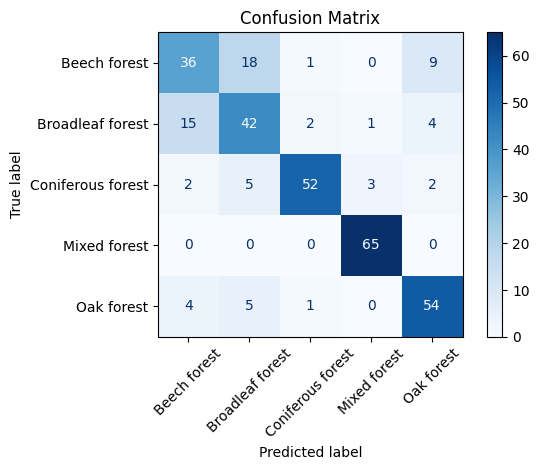

In [14]:
import geopandas as gpd
import rasterio
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# === Step 1: Load Raster ===
raster_path = '/content/stacked_with_texture_2017.tif'  # Update with your actual path
with rasterio.open(raster_path) as src:
    transform = src.transform
    raster_crs = src.crs
    num_bands = src.count
    raster_data = src.read()

# === Step 2: Load Shapefile ===
gdf = gpd.read_file('/content/ScoutAttempt2.shp')  # Update with your actual path
if gdf.crs != raster_crs:
    gdf = gdf.to_crs(raster_crs)

# === Step 3: Extract Features from Raster at Point Locations ===
coords = [(geom.x, geom.y) for geom in gdf.geometry]
with rasterio.open(raster_path) as src:
    sampled = np.array([val for val in src.sample(coords)])

# === Step 4: Mask Invalid Samples (NaNs) ===
valid_mask = ~np.isnan(sampled).any(axis=1)
X = sampled[valid_mask]
y = gdf.loc[valid_mask, 'Name'].values  # Adjust column name if needed

# === Step 5: Balance the Dataset with SMOTE ===
sm = SMOTE(random_state=42, k_neighbors=1)
X_bal, y_bal = sm.fit_resample(X, y)

# === Step 6: Define Model & Hyperparameter Grid ===
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
clf = RandomForestClassifier(random_state=42)
grid = GridSearchCV(clf, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)

# === Step 7: Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, stratify=y_bal, test_size=0.3, random_state=42)

# === Step 8: Train Best Model ===
grid.fit(X_train, y_train)
best_model = grid.best_estimator_

# === Step 9: Predict & Evaluate ===
y_pred = best_model.predict(X_test)

print("✅ Classification Report:")
print(classification_report(y_test, y_pred))

# === Step 10: Confusion Matrix ===
labels = sorted(list(set(y)))  # Ensure correct label order
cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()



Spatial cross validation modelling

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import geopandas as gpd
import rasterio

# === Load and Sample from Raster ===
raster_path = '/content/stacked_with_texture_2017.tif'
gdf = gpd.read_file('/content/ScoutAttempt2.shp')

with rasterio.open(raster_path) as src:
    raster_crs = src.crs
    if gdf.crs != raster_crs:
        gdf = gdf.to_crs(raster_crs)
    coords = [(geom.x, geom.y) for geom in gdf.geometry]
    sampled = np.array([val for val in src.sample(coords)])

# === Clean NaNs ===
valid_mask = ~np.isnan(sampled).any(axis=1)
X = sampled[valid_mask]
y = gdf.loc[valid_mask, 'Name'].values
coords_valid = np.array(coords)[valid_mask]

# === Spatial Cross-Validation Setup ===
n_folds = 5
gdf_valid = gdf.loc[valid_mask].copy()
gdf_valid["x"] = coords_valid[:, 0]
gdf_valid["fold"], bins = pd.qcut(gdf_valid["x"], q=n_folds, labels=False, retbins=True)

# === Hyperparameter Grid ===
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

# === Initialize Results ===
all_y_true = []
all_y_pred = []

# === Spatial CV Loop ===
for fold in range(n_folds):
    test_mask = gdf_valid["fold"] == fold
    train_mask = ~test_mask

    X_train, y_train = X[train_mask], y[train_mask]
    X_test, y_test = X[test_mask], y[test_mask]

    # Balance training data
    sm = SMOTE(random_state=42, k_neighbors=1)
    try:
        X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)
    except ValueError:
        print(f"⚠️ Skipping fold {fold} due to insufficient samples for SMOTE")
        continue

    # GridSearch
    clf = RandomForestClassifier(random_state=42)
    grid = GridSearchCV(clf, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
    grid.fit(X_train_bal, y_train_bal)
    best_model = grid.best_estimator_

    # Predict
    y_pred = best_model.predict(X_test)
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# === Final Report ===
print("✅ Spatial CV Classification Report:")
print(classification_report(all_y_true, all_y_pred))


✅ Spatial CV Classification Report:
                   precision    recall  f1-score   support

     Beech forest       0.58      0.58      0.58       214
 Broadleaf forest       0.28      0.34      0.30       128
Coniferous forest       0.56      0.64      0.60        75
     Mixed forest       0.00      0.00      0.00        30
       Oak forest       0.47      0.40      0.43       105

         accuracy                           0.47       552
        macro avg       0.38      0.39      0.38       552
     weighted avg       0.46      0.47      0.46       552



In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

# === Helper Function: Extract Patch Features ===
def extract_patch_features(raster_data, coords, transform, patch_size=3):
    pad = patch_size // 2
    padded = np.pad(raster_data, ((0, 0), (pad, pad), (pad, pad)), mode='reflect')
    features = []
    for x, y in coords:
        col, row = ~transform * (x, y)  # Convert geo to pixel coords
        col, row = int(round(col)) + pad, int(round(row)) + pad
        patch = padded[:, row - pad:row + pad + 1, col - pad:col + pad + 1]
        features.append(patch.flatten())
    return np.array(features)

# === Load Raster and Shapefile ===
raster_path = '/content/stacked_with_texture_2017.tif'
gdf = gpd.read_file('/content/ScoutAttempt2.shp')

with rasterio.open(raster_path) as src:
    raster_crs = src.crs
    transform = src.transform
    raster_data = src.read()
    if gdf.crs != raster_crs:
        gdf = gdf.to_crs(raster_crs)

    # Extract coordinates
    coords = [(geom.x, geom.y) for geom in gdf.geometry]
    X_full = extract_patch_features(raster_data, coords, transform, patch_size=3)

# === Clean NaNs (just in case) ===
valid_mask = ~np.isnan(X_full).any(axis=1)
X = X_full[valid_mask]
y = gdf.loc[valid_mask, 'Name'].values
coords_valid = np.array(coords)[valid_mask]

# === Spatial Cross-Validation Setup ===
n_folds = 5
gdf_valid = gdf.loc[valid_mask].copy()
gdf_valid["x"] = coords_valid[:, 0]
gdf_valid["fold"], bins = pd.qcut(gdf_valid["x"], q=n_folds, labels=False, retbins=True)

# === Hyperparameter Grid ===
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

# === Initialize Results ===
all_y_true = []
all_y_pred = []

# === Spatial CV Loop ===
for fold in range(n_folds):
    test_mask = gdf_valid["fold"] == fold
    train_mask = ~test_mask

    X_train, y_train = X[train_mask], y[train_mask]
    X_test, y_test = X[test_mask], y[test_mask]

    # Balance training data
    sm = SMOTE(random_state=42, k_neighbors=1)
    try:
        X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)
    except ValueError:
        print(f"⚠️ Skipping fold {fold} due to SMOTE error")
        continue

    # Grid Search
    clf = RandomForestClassifier(random_state=42)
    grid = GridSearchCV(clf, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
    grid.fit(X_train_bal, y_train_bal)
    best_model = grid.best_estimator_

    # Predict
    y_pred = best_model.predict(X_test)
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# === Final Report ===
print("✅ Spatial CV Classification Report (with Patch Sampling):")
print(classification_report(all_y_true, all_y_pred))



✅ Spatial CV Classification Report (with Patch Sampling):
                   precision    recall  f1-score   support

     Beech forest       0.59      0.60      0.59       206
 Broadleaf forest       0.22      0.24      0.23       120
Coniferous forest       0.53      0.63      0.58        63
     Mixed forest       0.00      0.00      0.00        20
       Oak forest       0.51      0.45      0.47       101

         accuracy                           0.46       510
        macro avg       0.37      0.38      0.37       510
     weighted avg       0.45      0.46      0.46       510



# Tuned model with Augmented Mixed forest data

✅ Initial Classification Report:
                   precision    recall  f1-score   support

     Beech forest       0.62      0.56      0.59        64
 Broadleaf forest       0.59      0.64      0.62        64
Coniferous forest       0.93      0.81      0.87        64
     Mixed forest       0.94      1.00      0.97        65
       Oak forest       0.78      0.84      0.81        64

         accuracy                           0.77       321
        macro avg       0.77      0.77      0.77       321
     weighted avg       0.77      0.77      0.77       321


✅ Retrained Classification Report with Augmented Mixed Forest:
                   precision    recall  f1-score   support

     Beech forest       0.71      0.64      0.67        69
 Broadleaf forest       0.59      0.68      0.64        69
Coniferous forest       0.91      0.87      0.89        69
     Mixed forest       0.92      0.97      0.94        69
       Oak forest       0.85      0.80      0.82        69

         accu

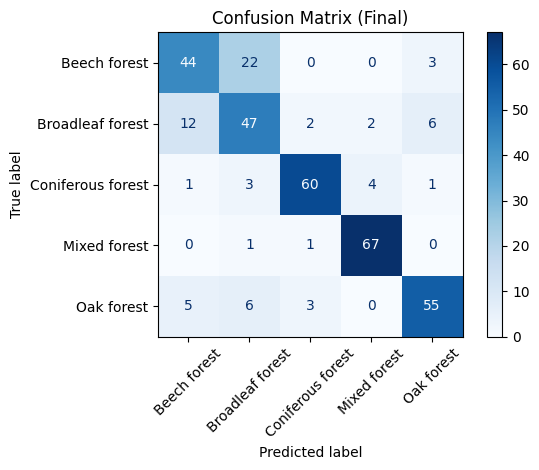

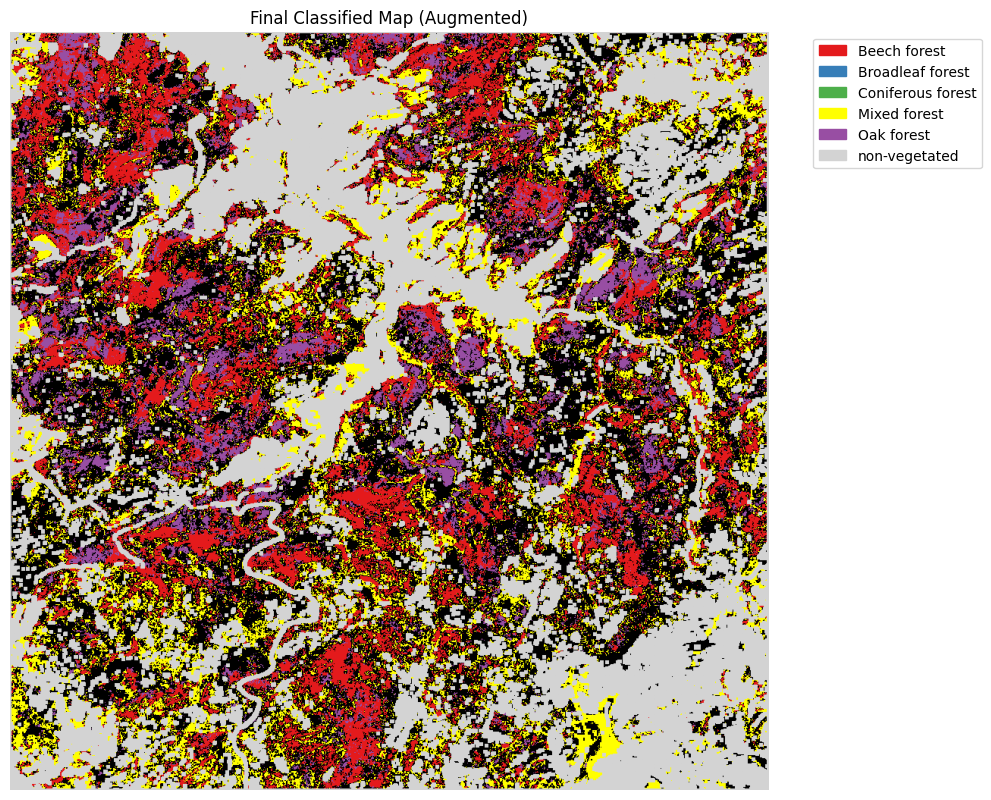

In [49]:
import geopandas as gpd
import rasterio
import numpy as np
import pandas as pd
from shapely.geometry import Point
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import random

# === Step 1: Load Raster ===
raster_path = '/content/stacked_with_texture_2017.tif'
with rasterio.open(raster_path) as src:
    transform = src.transform
    raster_crs = src.crs
    num_bands = src.count
    raster_data = src.read()

# === Step 2: Load Initial Training Shapefile ===
gdf = gpd.read_file('/content/ScoutAttempt2.shp')
if gdf.crs != raster_crs:
    gdf = gdf.to_crs(raster_crs)

# === Step 3: Extract Features from Raster at Point Locations ===
coords = [(geom.x, geom.y) for geom in gdf.geometry]
with rasterio.open(raster_path) as src:
    sampled = np.array([val for val in src.sample(coords)])

# === Step 4: Remove Invalid Samples ===
valid_mask = ~np.isnan(sampled).any(axis=1)
X = sampled[valid_mask]
y = gdf.loc[valid_mask, 'Name'].values

# === Step 5: Initial Training with SMOTE ===
sm = SMOTE(random_state=42, k_neighbors=1)
X_bal, y_bal = sm.fit_resample(X, y)

# === Step 6: Grid Search Random Forest ===
param_grid = {
    'n_estimators': [100],
    'max_depth': [10, None],
    'min_samples_split': [2, 5]
}
clf = RandomForestClassifier(random_state=42)
grid = GridSearchCV(clf, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)

# === Step 7: Train/Test Split and Fit ===
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, stratify=y_bal, test_size=0.3, random_state=42)
grid.fit(X_train, y_train)
best_model = grid.best_estimator_

# === Step 8: Predict and Evaluate ===
y_pred = best_model.predict(X_test)
print("✅ Initial Classification Report:")
print(classification_report(y_test, y_pred))

# === Step 9: Classify Entire Raster ===
rows, cols = raster_data.shape[1], raster_data.shape[2]
raster_reshaped = raster_data.reshape(num_bands, rows*cols).T
valid_pixels_mask = ~np.isnan(raster_reshaped).any(axis=1)
predicted_classes = np.array(['non-vegetated'] * (rows * cols))
valid_pixels = raster_reshaped[valid_pixels_mask]
predicted_valid = best_model.predict(valid_pixels)
predicted_classes[valid_pixels_mask] = predicted_valid
predicted_map = predicted_classes.reshape(rows, cols)

# === Step 10: Extract New Mixed Forest Samples from Predicted Map ===
mixed_points = []
for row in range(rows):
    for col in range(cols):
        if predicted_map[row, col] == 'Mixed forest':
            x, y = rasterio.transform.xy(transform, row, col)
            mixed_points.append(Point(x, y))

# Sample subset
random.seed(42)
sample_size = 200
if len(mixed_points) > sample_size:
    mixed_points = random.sample(mixed_points, sample_size)

# Create new GeoDataFrame
gdf_mixed = gpd.GeoDataFrame({'Name': ['Mixed forest'] * len(mixed_points)}, geometry=mixed_points, crs=raster_crs)
gdf_mixed.to_file('/content/MixedForest_Predicted_Points.shp')

# === Step 11: Augment Dataset and Extract Raster Values Again ===
gdf_aug = pd.concat([gdf, gdf_mixed], ignore_index=True)
coords_aug = [(geom.x, geom.y) for geom in gdf_aug.geometry]
with rasterio.open(raster_path) as src:
    sampled_aug = np.array([val for val in src.sample(coords_aug)])
valid_mask_aug = ~np.isnan(sampled_aug).any(axis=1)
X_aug = sampled_aug[valid_mask_aug]
y_aug = gdf_aug.loc[valid_mask_aug, 'Name'].values

# === Step 12: Reapply SMOTE & Retrain ===
X_aug_bal, y_aug_bal = sm.fit_resample(X_aug, y_aug)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_aug_bal, y_aug_bal, stratify=y_aug_bal, test_size=0.3, random_state=42)
grid.fit(X_train2, y_train2)
best_model_final = grid.best_estimator_
y_pred2 = best_model_final.predict(X_test2)

print("\n✅ Retrained Classification Report with Augmented Mixed Forest:")
print(classification_report(y_test2, y_pred2))

# === Step 13: Confusion Matrix ===
labels_sorted = sorted(set(y_aug_bal))
cm = confusion_matrix(y_test2, y_pred2, labels=labels_sorted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_sorted)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix (Final)")
plt.tight_layout()
plt.show()

# === Step 14: Final Map Prediction ===
final_prediction = np.array(['non-vegetated'] * (rows * cols))
valid_pixels2 = raster_reshaped[valid_pixels_mask]
predicted_valid2 = best_model_final.predict(valid_pixels2)
final_prediction[valid_pixels_mask] = predicted_valid2
final_map = final_prediction.reshape(rows, cols)

# === Step 15: Visualize Map with Color Codes ===
class_colors = {
    'Beech forest': '#e41a1c',        # red
    'Broadleaf forest': '#377eb8',    # blue
    'Coniferous forest': '#4daf4a',   # green
    'Mixed forest': '#ffff00',        # bright yellow
    'Oak forest': '#984ea3',          # purple
    'non-vegetated': '#d3d3d3'        # light gray
}

color_map = np.zeros((rows, cols, 3), dtype=np.float32)
for cls, hex_color in class_colors.items():
    mask = (final_map == cls)
    color_map[mask] = mcolors.to_rgb(hex_color)

plt.figure(figsize=(10, 10))
plt.imshow(color_map)
plt.title("Final Classified Map (Augmented)")
patches = [mpatches.Patch(color=hex, label=cls) for cls, hex in class_colors.items()]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axis('off')
plt.tight_layout()
plt.show()


# Spatial Cross validation with Augmented Mixed forest data

In [50]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
import geopandas as gpd
import rasterio
from shapely.geometry import Point
import random

# === Load Raster and Original Training Points ===
raster_path = '/content/stacked_with_texture_2017.tif'
gdf_orig = gpd.read_file('/content/ScoutAttempt2.shp')

with rasterio.open(raster_path) as src:
    raster_crs = src.crs
    raster_data = src.read()
    transform = src.transform
    num_bands = raster_data.shape[0]
    rows, cols = raster_data.shape[1:]

if gdf_orig.crs != raster_crs:
    gdf_orig = gdf_orig.to_crs(raster_crs)

# === Extract Features from Original Points ===
coords_orig = [(geom.x, geom.y) for geom in gdf_orig.geometry]
with rasterio.open(raster_path) as src:
    sampled_orig = np.array([val for val in src.sample(coords_orig)])

# === Clean Original Samples ===
valid_mask_orig = ~np.isnan(sampled_orig).any(axis=1)
X_orig = sampled_orig[valid_mask_orig]
y_orig = gdf_orig.loc[valid_mask_orig, 'Name'].values
coords_valid_orig = np.array(coords_orig)[valid_mask_orig]

# === Train Temporary Model to Predict Whole Raster ===
clf_temp = RandomForestClassifier(n_estimators=100, random_state=42)
sm = SMOTE(random_state=42, k_neighbors=1)
X_bal, y_bal = sm.fit_resample(X_orig, y_orig)
clf_temp.fit(X_bal, y_bal)

# === Predict Entire Raster ===
raster_reshaped = raster_data.reshape(num_bands, -1).T
valid_mask_raster = ~np.isnan(raster_reshaped).any(axis=1)
predicted_classes = np.array(['non-vegetated'] * raster_reshaped.shape[0])
predicted_classes[valid_mask_raster] = clf_temp.predict(raster_reshaped[valid_mask_raster])
predicted_map = predicted_classes.reshape(rows, cols)

# === Extract New Mixed Forest Points from Prediction Map ===
mixed_points = []
for row in range(rows):
    for col in range(cols):
        if predicted_map[row, col] == 'Mixed forest':
            x, y = rasterio.transform.xy(transform, row, col)
            mixed_points.append(Point(x, y))

# Sample subset of predicted points
random.seed(42)
sample_size = 200
if len(mixed_points) > sample_size:
    mixed_points = random.sample(mixed_points, sample_size)

gdf_mixed = gpd.GeoDataFrame({'Name': ['Mixed forest'] * len(mixed_points)},
                              geometry=mixed_points, crs=raster_crs)

# === Combine Original and New Mixed Points ===
gdf = pd.concat([gdf_orig, gdf_mixed], ignore_index=True)

# === Sample from Raster at All Point Locations ===
coords_all = [(geom.x, geom.y) for geom in gdf.geometry]
with rasterio.open(raster_path) as src:
    sampled_all = np.array([val for val in src.sample(coords_all)])

valid_mask = ~np.isnan(sampled_all).any(axis=1)
X = sampled_all[valid_mask]
y = gdf.loc[valid_mask, 'Name'].values
coords_valid = np.array(coords_all)[valid_mask]

# === Spatial CV Setup ===
n_folds = 5
gdf_valid = gdf.loc[valid_mask].copy()
gdf_valid["x"] = coords_valid[:, 0]
gdf_valid["fold"], bins = pd.qcut(gdf_valid["x"], q=n_folds, labels=False, retbins=True)

# === Hyperparameter Grid ===
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

# === Initialize Results ===
all_y_true = []
all_y_pred = []

# === Spatial CV Loop ===
for fold in range(n_folds):
    test_mask = gdf_valid["fold"] == fold
    train_mask = ~test_mask

    X_train, y_train = X[train_mask], y[train_mask]
    X_test, y_test = X[test_mask], y[test_mask]

    sm = SMOTE(random_state=42, k_neighbors=1)
    try:
        X_train_bal, y_train_bal = sm.fit_resample(X_train, y_train)
    except ValueError:
        print(f"⚠️ Skipping fold {fold} due to insufficient samples for SMOTE")
        continue

    clf = RandomForestClassifier(random_state=42)
    grid = GridSearchCV(clf, param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)
    grid.fit(X_train_bal, y_train_bal)
    best_model = grid.best_estimator_

    y_pred = best_model.predict(X_test)
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# === Final Report ===
print("✅ Spatial CV Classification Report (with added Mixed forest points):")
print(classification_report(all_y_true, all_y_pred))

✅ Spatial CV Classification Report (with added Mixed forest points):
                   precision    recall  f1-score   support

     Beech forest       0.59      0.57      0.58       214
 Broadleaf forest       0.33      0.33      0.33       128
Coniferous forest       0.54      0.69      0.61        75
     Mixed forest       0.91      0.94      0.93       230
       Oak forest       0.53      0.44      0.48       105

         accuracy                           0.64       752
        macro avg       0.58      0.59      0.59       752
     weighted avg       0.63      0.64      0.63       752

